In this tutorial, we will be creating a report that pulls data from a MySQL table that contains a list of the number of users who signed up on each day. From that, we'll construct a few queries and plug them into some of the default [Plot](https://kpi-reporter.readthedocs.io/en/latest/plugins/plot.html) visualizations to make it look nice. Here's what it should ultimately look like:

<img src="./example_output.png" width="400" style="border: 1px solid #cdcdcd;" />

Let's get started!

## Install KPI Reporter

For this tutorial, we will only need a few plugins. You can install `kpireport[all]` to install all available plugins.

In [8]:
pip install kpireport kpireport-mysql kpireport-plot kpireport-static

## Set up test database

For this tutorial, we'll be using a test database on a local MySQL server. A `initdb.sql` file has the test data; by updating this file and re-run this step you can re-seed the local database.

In [1]:
cat initdb.sql

CREATE DATABASE IF NOT EXISTS tutorial;

DROP TABLE IF EXISTS tutorial.new_users;
CREATE TABLE tutorial.new_users (
  `date` DATETIME NOT NULL,
  num_new_users INT DEFAULT 0
);

INSERT INTO tutorial.new_users (`date`, num_new_users)
VALUES
    (NOW() - INTERVAL 7 DAY, 10),
    (NOW() - INTERVAL 6 DAY, 13),
    (NOW() - INTERVAL 5 DAY, 4),
    (NOW() - INTERVAL 4 DAY, 7),
    (NOW() - INTERVAL 3 DAY, 10),
    (NOW() - INTERVAL 2 DAY, 18),
    (NOW() - INTERVAL 1 DAY, 9),
    (NOW(), 16);


In [3]:
# Start the server in the background
rm -f /tmp/mysql.sock.lock[[ -f /tmp/mysql.pid ]] || (mysqld &) && while [[ ! -f /tmp/mysql.pid ]]; do sleep 1; done
# Initialize the database and tables
mysql <initdb.sql && echo "Database initialized."

Database initialized.


## Run your first report

A `config.yaml` file contains our report configuration. We will start by defining a [**Datasource**](https://kpi-reporter.readthedocs.io/en/latest/api/datasource.html) for our MariaDB server and a [**View**](https://kpi-reporter.readthedocs.io/en/latest/api/view.html) displaying the result of a query as a bar chart. Here is the configuration this first report uses:

In [4]:
cat config.yaml

---
title: Quickstart Tutorial

datasources:
    my_db:
        plugin: mysql
        args:
            host: localhost
            user: ${USER}

views:
    num_users:
        plugin: plot
        args:
            datasource: my_db
            query: select * from tutorial.new_users
            kind: bar

outputs:
    html:
        plugin: static
        args:
            output_format: html
    png:
        plugin: static
        args:
            output_format: png


Let's break down what's going on.

* In the `datasources` section, we define a new Datasource and call it `my_db`. It uses the MySQL plugin, and allows us to query our MySQL database from within a particular View.
* In the `views` section, we define one view called `num_users`. It is going to show a bar chart of the number of users who signed up on that day. Our table has a `date` column already, so the plotter understands this should be plotted as time-based data. If we had a different column name we could use the `date_column` argument to give the plotter some help.
* In the `outputs` section we specify that we want the report outputted both in HTML and PNG format. Rendering a report like this to a static file (or group of files) is handled by the Static plugin.

We can now run the report and see how it goes:

In [8]:
kpireport -c config.yaml

INFO:kpireport.plugin:Loaded datasource plugins: ['mysql', 'jenkins', 'prometheus', 'googleanalytics']
INFO:kpireport.plugin:Initialized datasource my_db
INFO:kpireport.plugin:Loaded view plugins: ['jenkins.build_summary', 'plot', 'single_stat', 'prometheus.alert_summary', 'table']
INFO:kpireport.plugin:Initialized view num_users
INFO:kpireport.plugin:Loaded output driver plugins: ['s3', 'slack', 'scp', 'sendgrid', 'smtp', 'static']
INFO:kpireport.plugin:Initialized output driver html
INFO:kpireport.plugin:Initialized output driver png
INFO:kpireport.report:Sending report via output driver html
INFO:kpireport.report:Sending report via output driver png
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-jovyan'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Generated report in 2553.76ms.


If all went well, we should have a rendered report in the output directory (`_build` by default.)

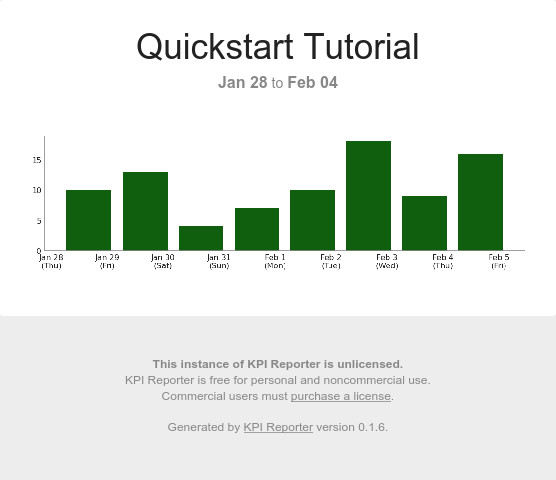

In [9]:
cat _build/latest-quickstart-tutorial.png | display

**View output**: [HTML](./_build/latest-quickstart-tutorial/index.html), [PNG](./_build/latest-quickstart-tutorial.png)

## Building out more views

We will now add a few new views:

1. Print the total number of users in the database as a [single stat](https://kpi-reporter.readthedocs.io/en/latest/plugins/plot.html#single-stat) view.
2. Show a plot of the total number of users over time, using a more advanced SQL query.

The updated configuration looks like this:

In [10]:
cat config-2.yaml

---
title: Quickstart Tutorial v2

datasources:
    my_db:
        plugin: mysql
        args:
            host: localhost
            user: ${USER}

views:
    num_users:
        cols: 4
        plugin: plot
        args:
            datasource: my_db
            query: select * from tutorial.new_users
            kind: bar
    total_users:
        title: Total new users
        cols: 2
        plugin: single_stat
        args:
            datasource: my_db
            query: select sum(num_new_users) from tutorial.new_users
    users_over_time:
        title: Users over time
        plugin: plot
        args:
            datasource: my_db
            query: |
                select `date`, (
                    select sum(num_new_users)
                    from tutorial.new_users u2 
                    where u2.`date` < u1.`date`
                ) as total_users
                from tutorial.new_users u1

outputs:
    html:
        plugin: static
        args:
            output_for

We'll re-run the report with this new configuration:

In [11]:
kpireport -c config-2.yaml

INFO:kpireport.plugin:Loaded datasource plugins: ['mysql', 'jenkins', 'prometheus', 'googleanalytics']
INFO:kpireport.plugin:Initialized datasource my_db
INFO:kpireport.plugin:Loaded view plugins: ['jenkins.build_summary', 'plot', 'single_stat', 'prometheus.alert_summary', 'table']
INFO:kpireport.plugin:Initialized view num_users
INFO:kpireport.plugin:Initialized view total_users
INFO:kpireport.plugin:Initialized view users_over_time
INFO:kpireport.plugin:Loaded output driver plugins: ['s3', 'slack', 'scp', 'sendgrid', 'smtp', 'static']
INFO:kpireport.plugin:Initialized output driver html
INFO:kpireport.plugin:Initialized output driver png
INFO:kpireport.report:Sending report via output driver html
INFO:kpireport.report:Sending report via output driver png
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-jovyan'
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
G

The report now renders in a few rows and has the additional views included:

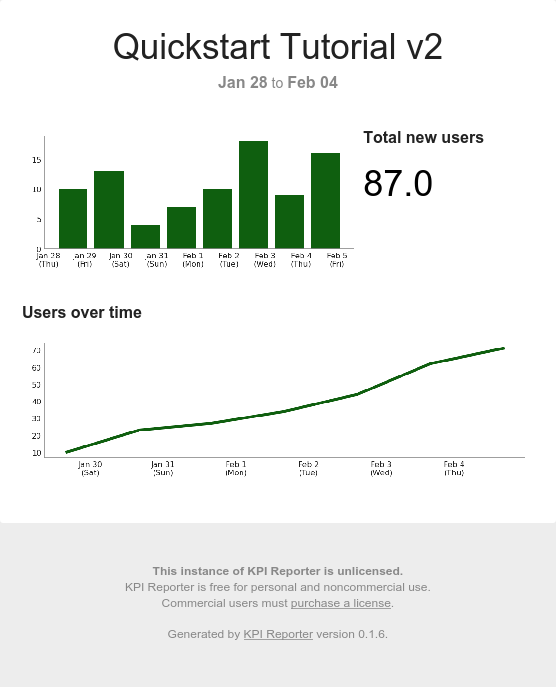

In [12]:
cat _build/latest-quickstart-tutorial-v2.png | display

**View output**: [HTML](./_build/latest-quickstart-tutorial/index.html), [PNG](./_build/latest-quickstart-tutorial.png)

Notice that we added a `title` to the single stat view to give more context as to what the number indicates. Additionally, the stat view was placed side-by-side with the first plot by adjusting the `columns` parameter for each view. By default every report uses a 6-column layout, but this [can be configured at the theme level](https://kpi-reporter.readthedocs.io/en/latest/api/report.html#kpireport.report.Theme.num_columns).

## Have fun!

This example has hopefully given you some ideas on how to get started creating your first report :)
If you are interested in not outputting HTML, but instead sending via email, refer to the plugin documentation for, e.g., the [SMTP](https://kpi-reporter.readthedocs.io/en/latest/plugins/smtp.html) or [SendGrid](https://kpi-reporter.readthedocs.io/en/stable/plugins/sendgrid.html) plugins.